# Improving MVP model
### Jeff Ho

This notebook shows improving the model from the initial MVP. 

**Question:**
Can we design and execute a method to predict the cuisine of a recipe given only its ingredients?

**Deliverables:**
Method that predicts a cuisine given its ingredients. 
Ideas to expand method to (1) understanding similarities/suggestions and 
(2) produce guidelines for a team to hand label cuisines based on ingredients.

**Why?**
To improve the product by building a feature for the food publication that enables users to query by cuisine.

In [27]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn import metrics

import pydotplus
from IPython.display import Image

### Build dataframe for modeling


In [79]:
# load data
raw_df = pd.read_json('recipies.json')
df = raw_df.explode('ingredients')
display(df.head())
display(len(df))

,id,cuisine,ingredients
0,10259,greek,romaine lettuce
0,10259,greek,black olives
0,10259,greek,grape tomatoes
0,10259,greek,garlic
0,10259,greek,pepper


428275

In [80]:
# Using top 20 ingredients here instead of top 10
freq_ingredients = ['salt', 'onions', 'olive oil', 'lime', 'water', 'garlic cloves', 'garlic', 'cachaca', 'sugar', 'tomatoes', 'coconut milk', 'sweetened condensed milk', 'pepper', 'eggs', 'ground black pepper', 'butter', 'milk', 'vegetable oil', 'black beans', 'bay leaves', 'all-purpose flour', 'unsalted butter', 'baking powder', 'large eggs', 'heavy cream', 'flour', 'baking soda', 'potatoes', 'kosher salt', 'carrots', 'vanilla extract', 'green bell pepper', 'cayenne pepper', 'cajun seasoning', 'green onions', 'celery', 'dried thyme', 'andouille sausage', 'creole seasoning', 'shrimp', 'soy sauce', 'sesame oil', 'corn starch', 'scallions', 'ginger', 'fresh ginger', 'rice vinegar', 'oil', 'oyster sauce', 'hoisin sauce', 'peanut oil', 'fish sauce', 'cooking oil', 'brown sugar', 'shallots', 'extra-virgin olive oil', 'dry white wine', 'fresh lemon juice', 'large egg yolks', 'dried oregano', 'feta cheese crumbles', 'feta cheese', 'cucumber', 'purple onion', 'lemon juice', 'lemon', 'fresh parsley', 'fresh dill', 'garam masala', 'ground turmeric', 'cumin seed', 'ground cumin', 'tumeric', 'chili powder', 'green chilies', 'curry powder', 'ground coriander', 'buttermilk', 'cabbage', 'grated parmesan cheese', 'fresh basil', 'black pepper', 'ground allspice', 'ground cinnamon', 'thyme', 'mirin', 'sake', 'sesame seeds', 'dashi', 'Gochujang base', 'toasted sesame seeds', 'kimchi', 'jalapeno chilies', 'sour cream', 'avocado', 'corn tortillas', 'salsa', 'chopped cilantro fresh', 'flour tortillas', 'ground ginger', 'paprika', 'couscous', 'chickpeas', 'cinnamon', 'beets', 'red bell pepper', 'saffron threads', 'flat leaf parsley', 'fresh lime juice', 'lemongrass', 'lime juice', 'cilantro leaves', 'beansprouts']
print(freq_ingredients)

['salt', 'onions', 'olive oil', 'lime', 'water', 'garlic cloves', 'garlic', 'cachaca', 'sugar', 'tomatoes', 'coconut milk', 'sweetened condensed milk', 'pepper', 'eggs', 'ground black pepper', 'butter', 'milk', 'vegetable oil', 'black beans', 'bay leaves', 'all-purpose flour', 'unsalted butter', 'baking powder', 'large eggs', 'heavy cream', 'flour', 'baking soda', 'potatoes', 'kosher salt', 'carrots', 'vanilla extract', 'green bell pepper', 'cayenne pepper', 'cajun seasoning', 'green onions', 'celery', 'dried thyme', 'andouille sausage', 'creole seasoning', 'shrimp', 'soy sauce', 'sesame oil', 'corn starch', 'scallions', 'ginger', 'fresh ginger', 'rice vinegar', 'oil', 'oyster sauce', 'hoisin sauce', 'peanut oil', 'fish sauce', 'cooking oil', 'brown sugar', 'shallots', 'extra-virgin olive oil', 'dry white wine', 'fresh lemon juice', 'large egg yolks', 'dried oregano', 'feta cheese crumbles', 'feta cheese', 'cucumber', 'purple onion', 'lemon juice', 'lemon', 'fresh parsley', 'fresh dill

In [81]:
%%time
#filter recipe list to only include top ingredients
id_top_ingredients_long = df.loc[df['ingredients'].isin(freq_ingredients)]
id_top_ingredients_long = id_top_ingredients_long[['id','ingredients']]

# add a column of ones so we can use .unstack to make a wide matrix
id_top_ingredients_long['ingredient'] = 1
id_top_ingredients_long.drop_duplicates(inplace=True)
id_top_ingredients_long.set_index(['id','ingredients'],inplace=True)
id_top_ingredients_long

# 1-hot encode the top 10 ingredients by cuisine in a wide matrix
id_top_ingredients_wide = id_top_ingredients_long.unstack(fill_value=0)
id_top_ingredients_wide

# join target column back in:
df_modeling = id_top_ingredients_wide.join(raw_df[['id','cuisine']].set_index('id'))
display(df_modeling)

# check join worked
display(df_modeling.loc[6]) #both should have "chinese" as cuisine
display(raw_df.loc[raw_df['id']==6])

,"(ingredient, Gochujang base)","(ingredient, all-purpose flour)","(ingredient, andouille sausage)","(ingredient, avocado)","(ingredient, baking powder)","(ingredient, baking soda)","(ingredient, bay leaves)","(ingredient, beansprouts)","(ingredient, beets)","(ingredient, black beans)",...,"(ingredient, sweetened condensed milk)","(ingredient, thyme)","(ingredient, toasted sesame seeds)","(ingredient, tomatoes)","(ingredient, tumeric)","(ingredient, unsalted butter)","(ingredient, vanilla extract)","(ingredient, vegetable oil)","(ingredient, water)",cuisine
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,spanish
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,mexican
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,french
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,chinese
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,chinese
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49712,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,indian
49713,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,southern_us
49714,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,irish


(ingredient, Gochujang base)             0
(ingredient, all-purpose flour)          0
(ingredient, andouille sausage)          0
(ingredient, avocado)                    0
(ingredient, baking powder)              0
                                    ...   
(ingredient, unsalted butter)            0
(ingredient, vanilla extract)            0
(ingredient, vegetable oil)              0
(ingredient, water)                      0
cuisine                            chinese
Name: 6, Length: 114, dtype: object

,id,cuisine,ingredients
16474,6,chinese,"[olive oil, sesame oil, soy sauce, flowering g..."


CPU times: user 470 ms, sys: 72 ms, total: 542 ms
Wall time: 500 ms


### Modeling

In [76]:
# Validation of model using built-in methods
def print_scores(X,y,model,y_names=None,class_report=False):
    print('Mean accuracy:')
    print(model.score(X,y))
    if class_report:
        print('Classification report')
        print(metrics.classification_report(y,model.predict(X),target_names=y_names,output_dict=True))
    

In [83]:
# Consider cuisines that have distinctive single items based on initial MVP
cuisines_most_distinctive = ['mexican','chinese','southern_us','italian','indian','thai']
df_modeling_all = df_modeling.copy
df_modeling = df_modeling.loc[df_modeling['cuisine'].isin(cuisines_most_distinctive)]

In [87]:
# Set up modeling

# Convert target string column to a factor
factor = pd.factorize(df_modeling['cuisine'])
df_modeling['cuisine_factor'] = factor[0]
definitions = factor[1]
print(df_modeling['cuisine_factor'].head())
# print(definitions)

y_col = 'cuisine_factor'
# Final features
feature_cols = df_modeling.columns[:-2]
print('Features:')
print(feature_cols.values)

X_train, X_test, y_train, y_test = train_test_split(
    df_modeling[feature_cols], df_modeling[y_col], test_size=0.20, random_state=22)

id
1     0
3     1
6     1
9     2
10    1
Name: cuisine_factor, dtype: int64
Features:
[('ingredient', 'Gochujang base') ('ingredient', 'all-purpose flour')
 ('ingredient', 'andouille sausage') ('ingredient', 'avocado')
 ('ingredient', 'baking powder') ('ingredient', 'baking soda')
 ('ingredient', 'bay leaves') ('ingredient', 'beansprouts')
 ('ingredient', 'beets') ('ingredient', 'black beans')
 ('ingredient', 'black pepper') ('ingredient', 'brown sugar')
 ('ingredient', 'butter') ('ingredient', 'buttermilk')
 ('ingredient', 'cabbage') ('ingredient', 'cachaca')
 ('ingredient', 'cajun seasoning') ('ingredient', 'carrots')
 ('ingredient', 'cayenne pepper') ('ingredient', 'celery')
 ('ingredient', 'chickpeas') ('ingredient', 'chili powder')
 ('ingredient', 'chopped cilantro fresh')
 ('ingredient', 'cilantro leaves') ('ingredient', 'cinnamon')
 ('ingredient', 'coconut milk') ('ingredient', 'cooking oil')
 ('ingredient', 'corn starch') ('ingredient', 'corn tortillas')
 ('ingredient', 'cous

/Users/Jeff/opt/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


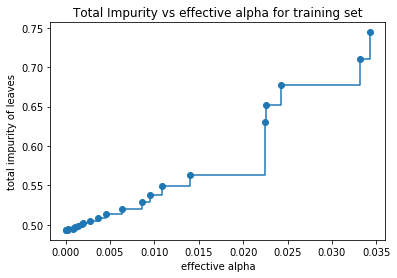

Number of nodes in the last tree is: 3 with ccp_alpha: 0.047334462095983354


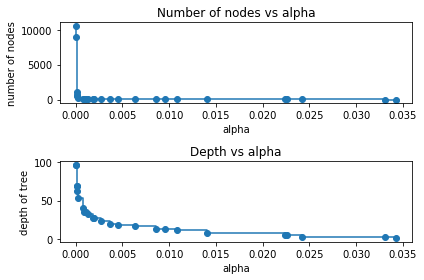

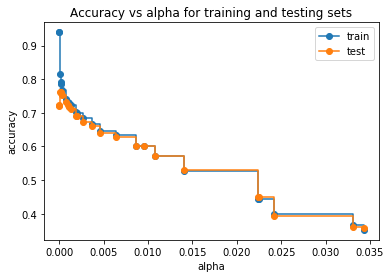

In [88]:
# Get ccp_alphas for cost complexity pruning
ct = tree.DecisionTreeClassifier(min_samples_leaf=400,random_state=0)
path = ct.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

clfs=[]
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()
plt.show()

train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

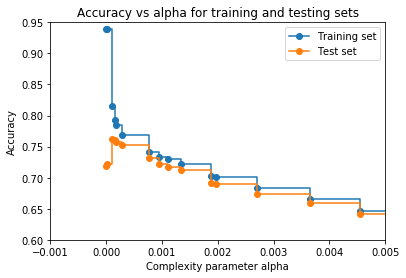

[0.7195704057279236, 0.7223548130469372, 0.7617342879872713, 0.7607398568019093, 0.7581543357199682, 0.7521877486077964, 0.7322991249005569, 0.7227525855210819, 0.7175815433571997, 0.7124105011933174, 0.6907319013524265, 0.6897374701670644, 0.6738265712012729, 0.6595067621320605, 0.6414081145584726, 0.6292760540970564, 0.6016308671439936, 0.6016308671439936, 0.572593476531424, 0.5296340493237868, 0.44968178202068415, 0.44968178202068415, 0.3941925218774861, 0.35918854415274465, 0.3577963404932379]
Optimal test accuracy: 0.5296340493237868
Optimal ccp_alpha: 0.014008946189621951


In [63]:
# zoom in to identify the optimal ccp_alpha
fig, ax = plt.subplots()
ax.set_xlabel("Complexity parameter alpha")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="Training set",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="Test set",
        drawstyle="steps-post")
ax.legend()
plt.xlim([-0.001, 0.005])
plt.ylim([0.6, 0.95])
plt.show()
print(test_scores)
optimal_text_score_index=19
print('Optimal test accuracy: {}'.format(test_scores[optimal_text_score_index]))
print('Optimal ccp_alpha: {}'.format(ccp_alphas[optimal_text_score_index]))

[0.20691088 0.14991661 0.14481729 0.10591005 0.10159229 0.09859884
 0.09636121 0.09589283 0.         0.         0.         0.
 0.         0.         0.        ]
['soy sauce' 'grated parmesan cheese' 'garam masala' 'corn tortillas'
 'extra-virgin olive oil' 'fish sauce' 'olive oil' 'flour tortillas'
 'fresh dill' 'dried thyme' 'fresh parsley' 'couscous' 'creole seasoning'
 'cucumber' 'cumin seed']


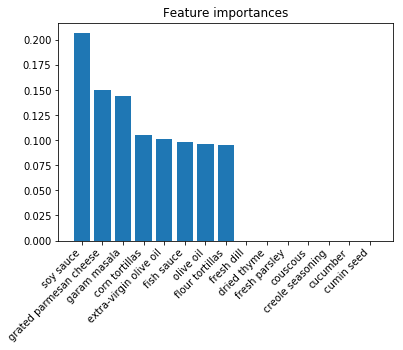

test data:
Mean accuracy:
0.5296340493237868
Classification report
{'mexican': {'precision': 0.991304347826087, 'recall': 0.2778229082047116, 'f1-score': 0.434010152284264, 'support': 1231}, 'chinese': {'precision': 0.7752161383285303, 'recall': 0.5046904315196998, 'f1-score': 0.6113636363636363, 'support': 533}, 'southern_us': {'precision': 0.2835648148148148, 'recall': 0.8677685950413223, 'f1-score': 0.42744984006978776, 'support': 847}, 'italian': {'precision': 0.7135023989033584, 'recall': 0.6803921568627451, 'f1-score': 0.696554031448645, 'support': 1530}, 'indian': {'precision': 0.9887640449438202, 'recall': 0.29042904290429045, 'f1-score': 0.4489795918367347, 'support': 606}, 'thai': {'precision': 0.9345794392523364, 'recall': 0.35587188612099646, 'f1-score': 0.5154639175257733, 'support': 281}, 'accuracy': 0.5296340493237868, 'macro avg': {'precision': 0.7811551973448245, 'recall': 0.49616250344229434, 'f1-score': 0.5223035282548069, 'support': 5028}, 'weighted avg': {'precisio

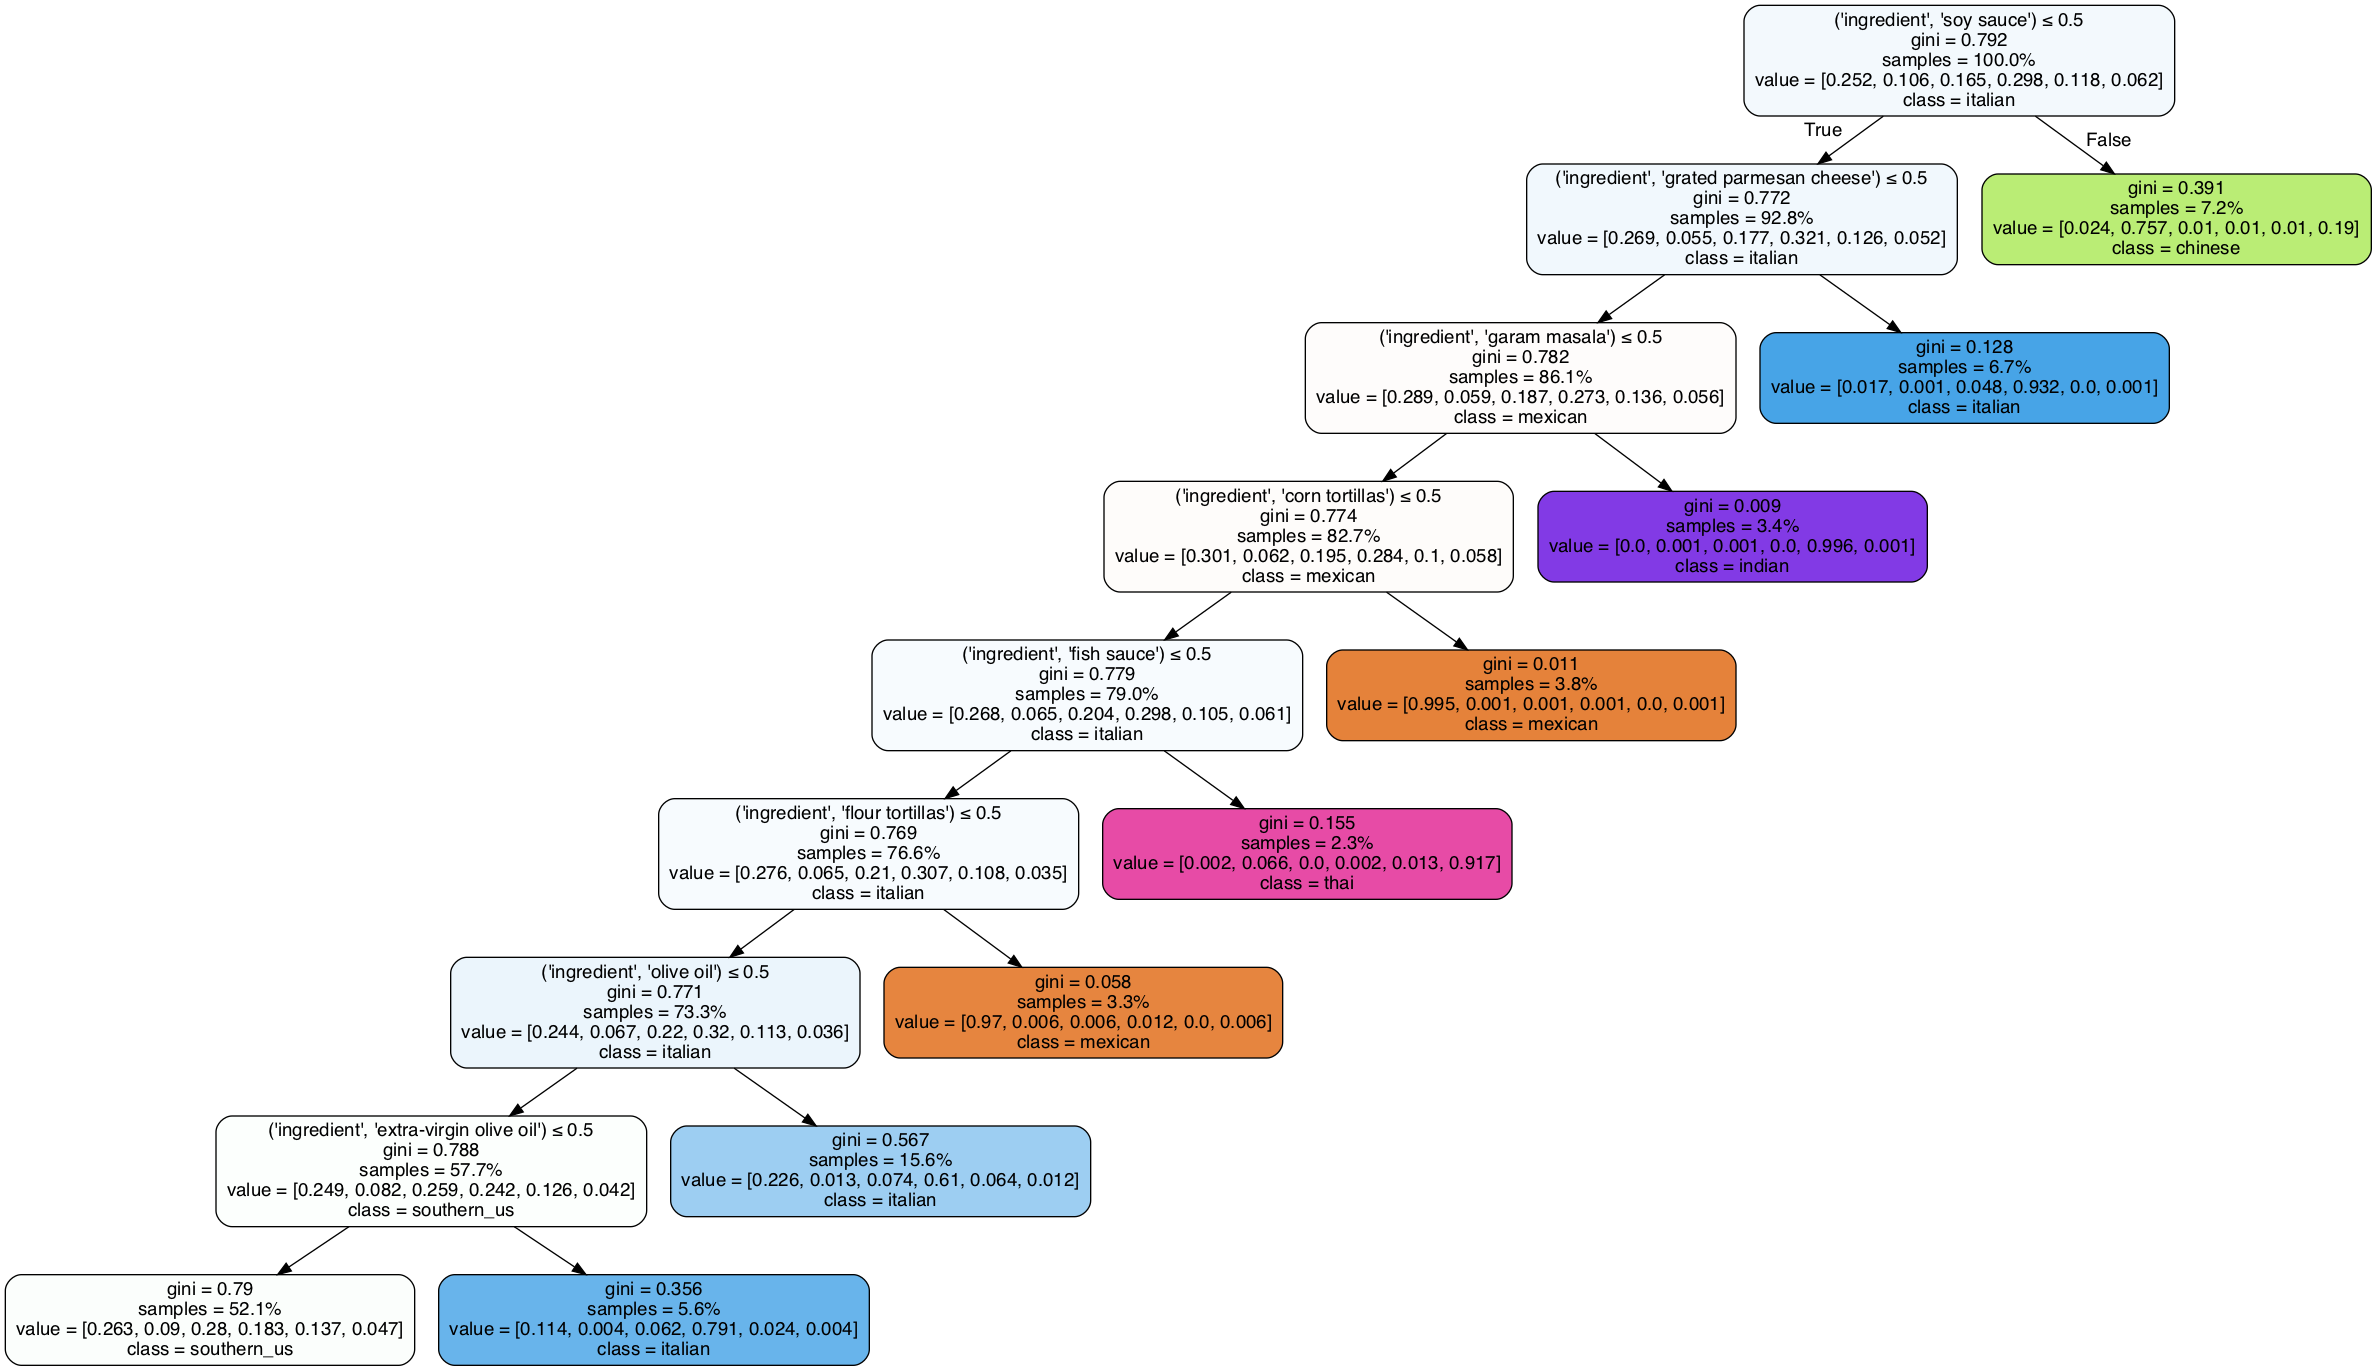

In [89]:
OPTIMAL_CCP_ALPHA = ccp_alphas[optimal_text_score_index]

# Use a classification tree for interpretability and non-linearity (e.g., soy sauce + etc)
ct = tree.DecisionTreeClassifier(min_samples_leaf=400,random_state=0,
                                 ccp_alpha=OPTIMAL_CCP_ALPHA)

ct.fit(X_train,y_train)

# What are the feature importances in the model?
importances = ct.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = [ingred_name[1] for ingred_name in feature_cols.values]

# Plot the feature importances
top_n = 15 #how many features to get out
print(importances[indices][0:top_n])
print(np.array(feature_names)[indices][0:top_n])
plt.figure()
plt.title("Feature importances")
plt.bar(np.array(feature_names)[indices][0:top_n], importances[indices][0:top_n], align="center")
plt.xticks(rotation=45,ha='right')
# plt.xticks(np.array(feature_names)[indices][0:top_n], indices)
plt.show()

#Show test and training acuracy
print('test data:')
print_scores(X_test,y_test,ct,y_names=definitions,class_report=True)

print('training data:')
print_scores(X_train,y_train,ct)

#Show tree
print('Tree:')
dot_data = tree.export_graphviz(ct, out_file=None, 
                         feature_names=feature_cols,  
                         class_names=list(definitions.values),  
                         filled=True, rounded=True,  
                         special_characters=True,
                         proportion=True)  
graph = pydotplus.graph_from_dot_data(dot_data) 

display(Image(graph.create_png()))

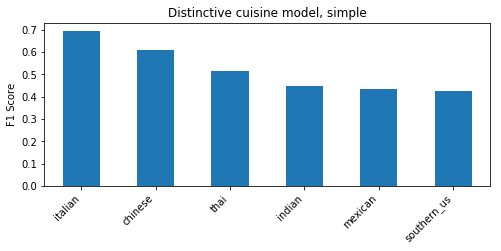

In [90]:
class_report = metrics.classification_report(y_test,ct.predict(X_test),
                                             target_names=definitions,output_dict=True)
df_cr = pd.DataFrame(class_report).transpose()
df_cr.drop(['accuracy','weighted avg','macro avg'],inplace=True)

fig,ax = plt.subplots(figsize=(8,3))
df_cr['f1-score'].sort_values(ascending=False).plot(ax=ax,kind='bar')
plt.xticks(rotation=45,ha='right')
plt.ylabel('F1 Score')
plt.title('Distinctive cuisine model, simple')
plt.show()

### Results
- The model trained on the top 20 ingredients for each cuisine performed only marginally better than for the top 10. 
- Restricting the scope of the problem to only predicting more popular cuisines improved accuracy to 75%. 
- Weighting the cuisines by the inverse of their frequency led to more selection of less popular cuisines but far lower accuracy overall.
- Tuning the hyperparameter of cost complexity aplha, tree complexity was reduced to improve interpretability of the tree, leading to clearer guidelines for hand-labelling.

### Next Steps
- Other re-sampling schemes (e.g., bootstrapping samples from larger classes) may improve prediction of less popular cuisines.
- Determining embeddings for ingredients, e.g., word2vec, would allow for understanding similarity/substitutions. However, the embeddings shouldn't be based on words alone as red onion/yellow onion might be similiar lexically but different in cooking.

